# Semi Gradient n-step SARSA
> Cart Pole Problem

In [79]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

## Env

https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space


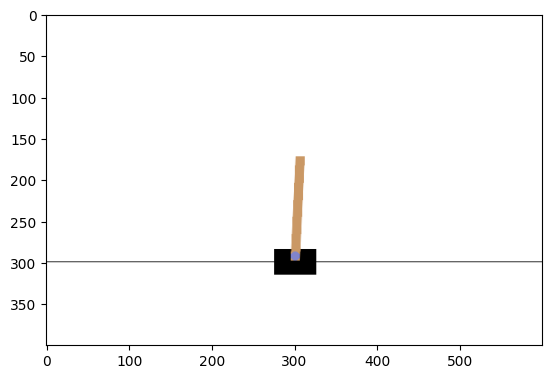

In [80]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# increase episode length from 200 to 4000
env._max_episode_steps = 4000

np.random.seed(13)
env.reset()
plt.imshow(env.render())

In [81]:
state, _ = env.reset()
print(state)

[ 0.0038904   0.0012998  -0.02776357  0.04863878]


In [82]:
print(env.action_space.sample())

0


## Random Action


In [83]:
total_reward = 0.0
total_steps = 0
timestamp = int(datetime.datetime.now().timestamp())
env = RecordVideo(env=env, video_folder="./video", name_prefix=timestamp)
obs, _ = env.reset()

done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    total_steps += 1
    done = terminated or truncated
    if total_steps % 200 == 0:
        print(
            f"Step {total_steps:2d}: action={action:2d}, Reward={reward:5.2f}, "
            f"Terminated={terminated}, Truncated={truncated}, info={info}"
        )

print(
    f"Episode finished after {total_steps} steps with total reward: {total_reward:.2f}"
)
env.close()

Episode finished after 15 steps with total reward: 15.00


c:\Users\admin\Coding\research\rl-training-2025-codes\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\admin\Coding\research\rl-training-2025-codes\src\T04_functional_approx\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Reinforcement Learning


In [84]:
# The implementation of tiles3 is from Richard Sutton's website
# http://incompleteideas.net/tiles/tiles3.html
from tiles3 import IHT, tiles

In [85]:
class QEstimator:
    def __init__(
        self, step_size, num_of_tilings=8, tiles_per_dim=8, max_size=2048, epsilon=0.0
    ):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.tiles_per_dim = tiles_per_dim
        self.epsilon = epsilon
        self.step_size = step_size / num_of_tilings

        self.table = IHT(max_size)

        self.w = np.zeros(max_size)

        # Based on values from https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space
        # The Cart Velocity and Pole Angular Velocity ranges are set heuristically.
        self.env_observation_space_high = [4.8, 5, 0.418, 5]
        self.env_observation_space_low = [-4.8, -5, -0.418, -5]

        self.cart_pos_scale = self.tiles_per_dim / (
            self.env_observation_space_high[0] - self.env_observation_space_low[0]
        )
        self.cart_vel_scale = self.tiles_per_dim / (
            self.env_observation_space_high[1] - self.env_observation_space_low[1]
        )
        self.pole_angle_scale = self.tiles_per_dim / (
            self.env_observation_space_high[2] - self.env_observation_space_low[2]
        )
        self.pole_angle_vel_scale = self.tiles_per_dim / (
            self.env_observation_space_high[3] - self.env_observation_space_low[3]
        )

    def get_active_features(self, state, action):
        cart_pos, cart_vel, pole_angle, pole_angle_vel = state
        active_features = tiles(
            self.table,
            self.num_of_tilings,
            [
                self.cart_pos_scale * (cart_pos - self.env_observation_space_low[0]),
                self.cart_vel_scale * (cart_vel - self.env_observation_space_low[1]),
                self.pole_angle_scale
                * (pole_angle - self.env_observation_space_low[2]),
                self.pole_angle_vel_scale
                * (pole_angle_vel - self.env_observation_space_low[3]),
            ],
            [action],
        )
        return active_features

    def q_predict(self, state, action):
        active_features = self.get_active_features(state, action)
        return np.sum(self.w[active_features])

    # learn with given state, action and target
    def q_update(self, state, action, target):
        active_features = self.get_active_features(state, action)
        q_s_a = np.sum(self.w[active_features])
        delta = target - q_s_a
        self.w[active_features] += self.step_size * delta

    def get_eps_greedy_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(env.action_space.n)
        else:
            qvals = np.array(
                [self.q_predict(state, action) for action in range(env.action_space.n)]
            )
            return np.argmax(qvals)

In [86]:
def sarsa_n(qhat, env, n=1, gamma=1.0, episode_cnt=10000):
    episode_rewards = []
    print_every = max(1, episode_cnt // 10) 
    for ec in range(episode_cnt):
        if ec % print_every == 0 or ec == episode_cnt - 1:
            print(f"Episode: {ec + 1}/{episode_cnt}")
        state, _ = env.reset()
        action = qhat.get_eps_greedy_action(state)
        T = float("inf")
        t = 0
        states = [state]
        actions = [action]
        rewards = [0.0]
        while True:
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                states.append(next_state)
                rewards.append(reward)

                if done:
                    T = t + 1
                else:
                    next_action = qhat.get_eps_greedy_action(next_state)
                    actions.append(next_action)

            tau = t - n + 1

            if tau >= 0:
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += gamma ** (i - tau - 1) * rewards[i]
                if tau + n < T:
                    G += gamma**n * qhat.q_predict(states[tau + n], actions[tau + n])
                qhat.q_update(states[tau], actions[tau], G)

            if tau == T - 1:
                episode_rewards.append(np.sum(rewards))
                break
            else:
                t += 1
                state = next_state
                action = next_action

    return np.array(episode_rewards)

In [87]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name, np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    # plt.ylim(-500, 0)
    plt.show()

In [88]:
# Create a n-SARSA Learning agent
step_size = 0.2
n = 4
epsilon = 0.01
gamma = 1.0
estimator = QEstimator(step_size, epsilon=epsilon, max_size=10000)
reward_arr = []

[ 0.03647976  0.03553025  0.03110234 -0.02385536]
Episode: 1/10
Episode: 2/10
Episode: 3/10
Episode: 4/10
Episode: 5/10
Episode: 6/10
Episode: 7/10
Episode: 8/10
Episode: 9/10
Episode: 10/10


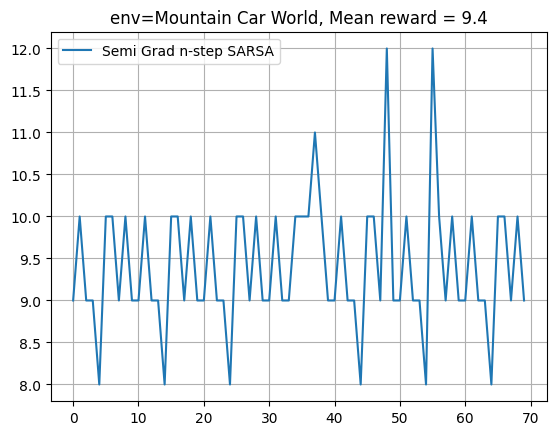

In [97]:
# episode_cnt = 500
episode_cnt = 10

# Initialize environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset(seed=13)
print(state)
rewards = sarsa_n(
    estimator,
    env=env,
    n=n,
    gamma=gamma,
    episode_cnt=episode_cnt,
)
reward_arr = [*reward_arr, *rewards]
# plot rewards
plot_rewards("Cart Pole", reward_arr, "Semi Grad n-step SARSA")

### Take a look into the agent


In [90]:
state = env.observation_space.sample()
action = env.action_space.sample()
print("=" * 40)
print(f"Sampled state:  {state}")
print(f"Sampled action: {action}")
print("=" * 40)

active_features = estimator.get_active_features(state=state, action=action)
print("Active features for selected state-action pair:")
print(active_features)
print("=" * 40)

q_pred = [estimator.q_predict(state=state, action=a) for a in range(env.action_space.n)]
print("Q-value predictions for all actions:")
for idx, q in enumerate(q_pred):
    print(f"  Action {idx}: {q:.3f}")
print("=" * 40)

a_greedy = estimator.get_eps_greedy_action(state=state)
print(f"Epsilon-greedy action for sampled state: {a_greedy}")
print("=" * 40)

Sampled state:  [-1.253599   -0.57662505 -0.38998106 -0.6090739 ]
Sampled action: 1
Active features for selected state-action pair:
[173, 174, 175, 176, 177, 178, 179, 180]
Q-value predictions for all actions:
  Action 0: 0.000
  Action 1: 0.000
Epsilon-greedy action for sampled state: 0


## Take a look at the result


In [91]:
env.close()
env = gym.make("CartPole-v1", render_mode="rgb_array")
timestamp = int(datetime.datetime.now().timestamp())
timestamp = int(datetime.datetime.now().timestamp())
env = RecordVideo(env=env, video_folder="./video", name_prefix=timestamp)
rewards = sarsa_n(
    estimator,
    env=env,
    n=n,
    gamma=gamma,
    episode_cnt=1,
)
env.close()

Episode: 1/1
